<a href="https://colab.research.google.com/github/Maruf1904002/Fake-News-Detection/blob/main/Fake_News_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection
This notebook downloads the **Fake and Real News Dataset** from Kaggle, preprocesses the data, trains a machine learning model, and evaluates it using accuracy, precision, recall, F1-score, and a confusion matrix.

## Step 1: Setup Kaggle API

In [1]:
# Upload kaggle.json from your local machine (Kaggle API key)
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset -p /content
!unzip -o /content/fake-and-real-news-dataset.zip -d /content/fake_real_news
!ls -l /content/fake_real_news


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 758MB/s]
Archive:  /content/fake-and-real-news-dataset.zip
  inflating: /content/fake_real_news/Fake.csv  
  inflating: /content/fake_real_news/True.csv  
total 113648
-rw-r--r-- 1 root root 62789876 Apr 19  2024 Fake.csv
-rw-r--r-- 1 root root 53582940 Apr 19  2024 True.csv


## Step 2: Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Step 3: Load Dataset

In [3]:
true_df = pd.read_csv("/content/fake_real_news/True.csv")
fake_df = pd.read_csv("/content/fake_real_news/Fake.csv")

# Assign labels: 1 = True, 0 = Fake
true_df["label"] = 1
fake_df["label"] = 0

# Merge
df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Combine title + text
df["content"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()

print(df.head())
print("Class balance:\n", df["label"].value_counts())


                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text       subject  \
0  Donald Trump s White House is in chaos, and th...          News   
1  Now that Donald Trump is the presumptive GOP n...          News   
2  Mike Pence is a huge homophobe. He supports ex...          News   
3  SAN FRANCISCO (Reuters) - California Attorney ...  politicsNews   
4  Twisted reasoning is all that comes from Pelos...      politics   

               date  label                                            content  
0     July 21, 2017      0  BREAKING: GOP Chairman Grassley Has Had Enough...  
1       May 7, 2016      0  Failed GOP Candidates Remembered In Hilarious ...  
2 

## Step 4: Split Dataset

In [4]:
X = df["content"]
y = df["label"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 35918
Validation size: 4490
Test size: 4490


## Step 5: Build Model Pipeline

In [5]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=3)),
    ("clf", LinearSVC())
])

pipe.fit(X_train, y_train)

# Validation performance
y_val_pred = pipe.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=3))


Validation Accuracy: 0.9944320712694877
              precision    recall  f1-score   support

           0      0.995     0.994     0.995      2348
           1      0.993     0.995     0.994      2142

    accuracy                          0.994      4490
   macro avg      0.994     0.994     0.994      4490
weighted avg      0.994     0.994     0.994      4490



## Step 6: Test Performance and Metrics

Test Accuracy: 0.9971046770601336
              precision    recall  f1-score   support

           0      0.997     0.997     0.997      2348
           1      0.997     0.997     0.997      2142

    accuracy                          0.997      4490
   macro avg      0.997     0.997     0.997      4490
weighted avg      0.997     0.997     0.997      4490



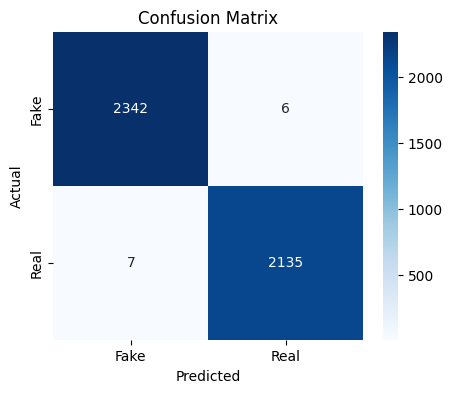

In [6]:
y_test_pred = pipe.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Step 7: Save trained model (Pipeline) to Drive + Load it later

In [7]:
# --- Mount Drive (run each new Colab session) ---
from google.colab import drive
drive.mount('/content/drive')

# --- Save trained pipeline ---
# NOTE: We're saving the variable `pipe` (your TF-IDF + LinearSVC Pipeline).
# If you used a different variable name (e.g., best_model from GridSearch),
# change `pipe` to that variable.
import joblib, os, time

OUT_DIR = "/content/drive/MyDrive/fake_news_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

model_filename = "tfidf_linearSVC_pipeline.joblib"   # fixed name
# Optional: add a timestamped backup copy
ts_filename = f"tfidf_linearSVC_pipeline_{int(time.time())}.joblib"

# Save the current model
joblib.dump(pipe, os.path.join(OUT_DIR, model_filename))
joblib.dump(pipe, os.path.join(OUT_DIR, ts_filename))

print("Saved model to:")
print(" -", os.path.join(OUT_DIR, model_filename))
print(" -", os.path.join(OUT_DIR, ts_filename), "(backup)")

# --- Load the model later (no retraining needed) ---
loaded_model_path = os.path.join(OUT_DIR, model_filename)
loaded_pipe = joblib.load(loaded_model_path)
print("Loaded model from:", loaded_model_path)

# Quick sanity check (optional)
print("Sanity check prediction:", loaded_pipe.predict(["Government announces new policy on education."])[0])


Mounted at /content/drive
Saved model to:
 - /content/drive/MyDrive/fake_news_artifacts/tfidf_linearSVC_pipeline.joblib
 - /content/drive/MyDrive/fake_news_artifacts/tfidf_linearSVC_pipeline_1755339161.joblib (backup)
Loaded model from: /content/drive/MyDrive/fake_news_artifacts/tfidf_linearSVC_pipeline.joblib
Sanity check prediction: 0


## Step 8: Try Prediction on New Text (using the loaded model)

In [13]:
def predict_label(text: str, model=None):
    model = model or loaded_pipe  # default to the loaded model
    pred = model.predict([text])[0]
    return "REAL" if pred == 1 else "FAKE"

print(predict_label("Shocking! Secret cure for everything revealed by celebrities."))
print(predict_label("NASA’s Perseverance rover has collected rock samples that may contain signs of ancient microbial life on Mars."))
print(predict_label("Bangladesh inaugurated a new bridge over the Padma River to boost connectivity and trade in the region."))
print(predict_label("The World Health Organization announced that a new malaria vaccine has completed successful clinical trials and will be distributed in Africa starting next year."))
print(predict_label("NASA’s Perseverance rover collected rock samples on Mars that could show evidence of ancient microbial life, according to researchers."))
print(predict_label("The Federal Reserve said in a press release that it will keep interest rates steady this quarter, citing ongoing inflation concerns."))
print(predict_label("Bangladesh has officially inaugurated the Padma Bridge, improving national connectivity and boosting trade across the country."))
print(predict_label("Japan has reopened its borders to international tourists as COVID-19 cases continue to decline, the Prime Minister confirmed on Monday."))




FAKE
FAKE
REAL
FAKE
FAKE
REAL
REAL
REAL
